In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import hashlib

from itertools import combinations, islice

## Load databases

In [2]:
col_project_languages = ["project_id","language","bytes","created_at"]
col_project_members = ["project_id","user_id","created_at"]

In [3]:
project_languages = pd.read_csv("dump/project_languages.csv",low_memory=False,names=col_project_languages)

In [4]:
# Remove created_at and remove duplicates
project_languages = project_languages[["project_id","language","bytes"]].drop_duplicates()

In [5]:
# Remove NaNs
project_languages = project_languages.dropna()

In [6]:
## Keep the most frequent language
project_languages = project_languages.sort_values(by=['project_id','bytes'], ascending=[True,False])

In [7]:
## Keep the most frequent language
project_languages = project_languages.drop_duplicates(subset=["project_id"],keep="first")

In [8]:
# Load members
project_members = pd.read_csv("dump/project_members.csv",low_memory=False,names=col_project_members)

In [11]:
# Encrypt user id
project_members.loc[:,"user_id"] = [hashlib.sha256(str(x.user_id).encode('utf-8')).hexdigest()[:10] for k,x in project_members.iterrows()]

In [12]:
# Left join project_members with project_languages
project_members = pd.merge(project_members,
                           project_languages[["project_id","language"]],
                           how="left",
                           on="project_id")

In [13]:
# Remove project_members without a language
project_members = project_members.dropna()

In [14]:
# Remove users who had more than 40 projects and fewer than 80 projects
freq_users = project_members.groupby("user_id").size().sort_values(ascending=False)
freq_users = freq_users[(freq_users > 40) & (freq_users < 80)]
project_members_filtered = project_members[project_members.user_id.isin(freq_users.index)]

## Descriptives

In [15]:
project_languages.head()

project_id language     bytes
27958097           1     ruby    108686
14613891           2     ruby    110925
17409693           3      c++   4398590
9280525            5        c  24018256
72486550           6      c++  30703904

In [16]:
project_members_filtered

project_id     user_id           created_at    language
16                 3  f808f79250  2011-06-24 18:29:24         c++
28                 6  6a287a1078  2010-11-18 22:17:00         c++
36                 8  b0ab628c9e  2012-05-23 18:26:47        ruby
91                34  e830a0d7d5  2011-09-08 14:52:50  javascript
97                34  1f74494f92  2011-09-08 14:52:50  javascript
...              ...         ...                  ...         ...
15522709   207036311  59a183a2fc  2021-03-05 20:20:32        ruby
15523177   207052392  bafaf4a4e2  2021-03-05 15:55:39        html
15523607   207071183  5901437381  2021-03-05 07:17:00        java
15523731   207076427  5901437381  2021-03-05 09:46:50          c#
15523732   207076448  5901437381  2021-03-05 09:48:24  javascript

[190037 rows x 4 columns]

In [17]:
project_members_filtered.groupby("language").size().sort_values(ascending=False)[0:20]

language
javascript      48453
java            23504
ruby            20756
python          19129
php             13137
html             9786
css              7931
shell            7042
c++              4454
c#               3722
c                3411
objective-c      3035
etag             3000
go               2765
perl             2227
coffeescript     1799
scala            1302
clojure          1219
swift             869
r                 840
dtype: int64

## Define function

In [18]:
def create_database(selected_language):
    # Select projects with the selected language
    selected_projects_ids = project_members_filtered[project_members_filtered.language == selected_language].project_id.unique()
    
    # Create edgelist
    edgelist = []

    # Create the network and extract tags for authors
    for i, idx in enumerate(selected_projects_ids):
        # Get users ids
        proj_users = project_members_filtered[project_members_filtered.project_id == idx].user_id.unique()

        # Create the edges among project's users
        edges = combinations(sorted(list(proj_users)), 2) 

        # Add edges to the edgelist
        edgelist.extend(list(edges))

        # Print
        if i % 1000 == 0:
            print(i)
    
    # Transform edgelist to a dataframe
    edgelist_df = pd.DataFrame(edgelist, columns=['source', 'target'])
    
    # Keep ties with more than two occurrences
    edgelist_frequency = edgelist_df.groupby(["source","target"]).size().sort_values(ascending=False)
    edgelist_df = edgelist_frequency[edgelist_frequency > 2].reset_index()
    
    # Redefine columns
    edgelist_df.columns = ["source","target","weight"]
    
    # Create the network
    G = nx.from_pandas_edgelist(edgelist_df, edge_attr=True)
    
    # Check descriptives
    print("Number of nodes: " + str(G.number_of_nodes()))
    
    # Check descriptives
    print("Number of edges: " + str(G.number_of_edges()))
    
    # Find the largest component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    
    # Check descriptives
    print("Number of nodes of largest component: " + str(G0.number_of_nodes()))
    
    # Plot configuration
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

    # Plot graph
    options = {
        'node_size': 1,
    }
    
    # Plot graph
    nx.draw(G0, with_labels=False, font_weight='bold', **options)
    plt.show()
    
    # Create variable with selected users
    selected_users = list(G0.nodes)
    
    # Identify and save selected users' languages
    users_languages = {}
    for s in selected_users:
        user_languages = project_members[project_members.user_id == s].groupby("language").size()
        users_languages[s] = {}
        for k,j in user_languages.iteritems():
            # Only if the user has contributed in more than 2
            if j > 2:
                users_languages[s][k] = j

    # Check distribution of users' languages
    users_languages_count = [(key, len(x)) for key, x in users_languages.items()]
    users_languages_count = sorted(users_languages_count, key=lambda x: x[1], reverse=True)

    # Get the list of languages
    languages_dict = {}
    for key, values in users_languages.items():
        for value in values:
            if value not in languages_dict:
                languages_dict[value] = 0
            languages_dict[value] = languages_dict[value] + 1

    # Sort languages
    languages_dict = dict(sorted(languages_dict.items(), key=lambda item: item[1], reverse=True))

    # Check languages
    languages_dict

    # Select top-6 languages
    num_skills = min(6, len(languages_dict))
    languages_top = [x[0] for x in list(islice(languages_dict.items(), num_skills))]

    # Select users that have those languages
    selected_users_2 = [key for key, languages in users_languages.items() if any(item in languages_top for item in languages.keys())]
    selected_users_2 = { user: users_languages[user] for user in selected_users_2 }

    # Remove other values and set the top tags in each author
    for user, languages in selected_users_2.items():
        selected_users_2[user] = { language: languages[language] if language in languages.keys() else 0 for language in languages_top}

    # Export relationship data
    relationships = nx.to_pandas_edgelist(G0)
    relationships.to_csv('ghtorrent_'+ selected_language + '_relationships.csv')

    # Get the key dict for the largest component
    G0_users_languages = { g: selected_users_2[g] for g in list(G0.nodes) }

    # Covert dictionary to a dataframe
    skills = pd.DataFrame.from_dict(G0_users_languages).T
    skills.columns = ["skill." + str(i) for i in range(1,len(skills.columns)+1)]

    # Export skills data
    skills.to_csv('ghtorrent_'+ selected_language +'_users_profiles.csv')


c
0
1000
2000
Number of nodes: 128
Number of edges: 636
Number of nodes of largest component: 32


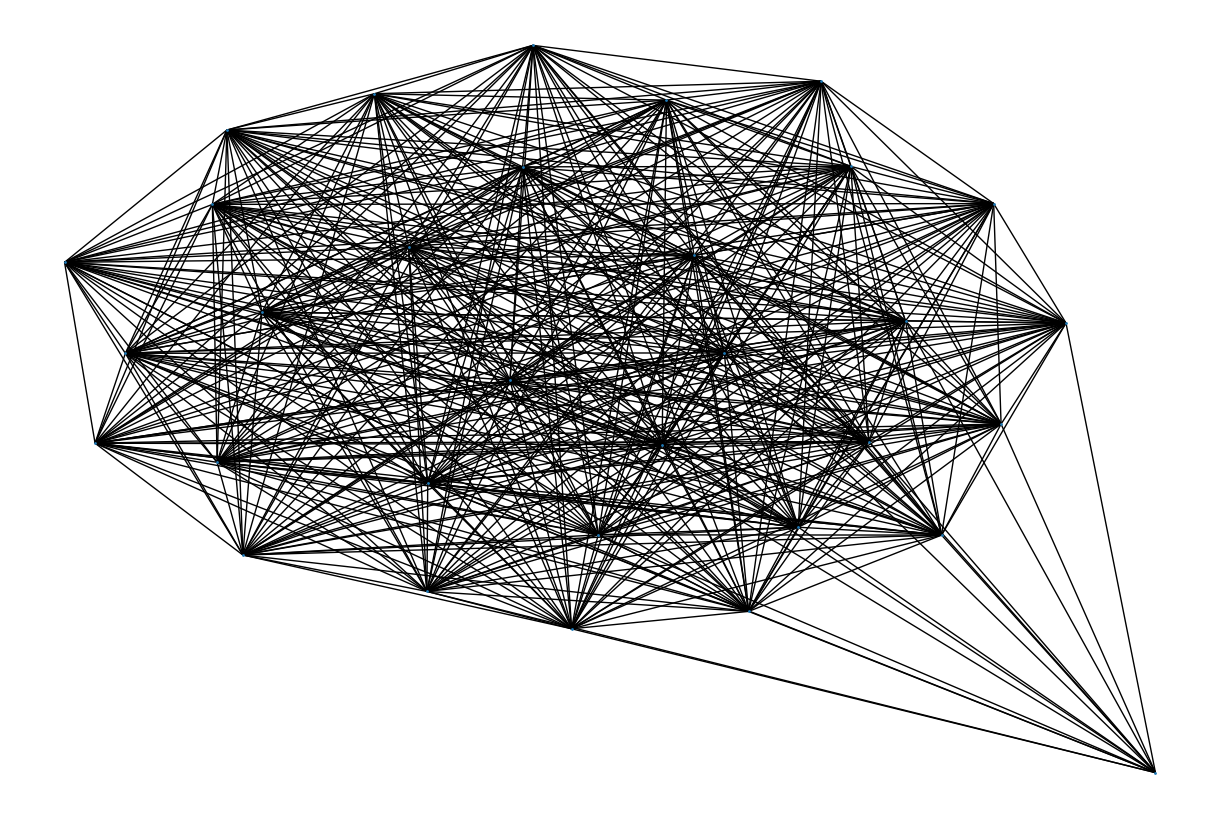

javascript
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
Number of nodes: 1560
Number of edges: 25796
Number of nodes of largest component: 376


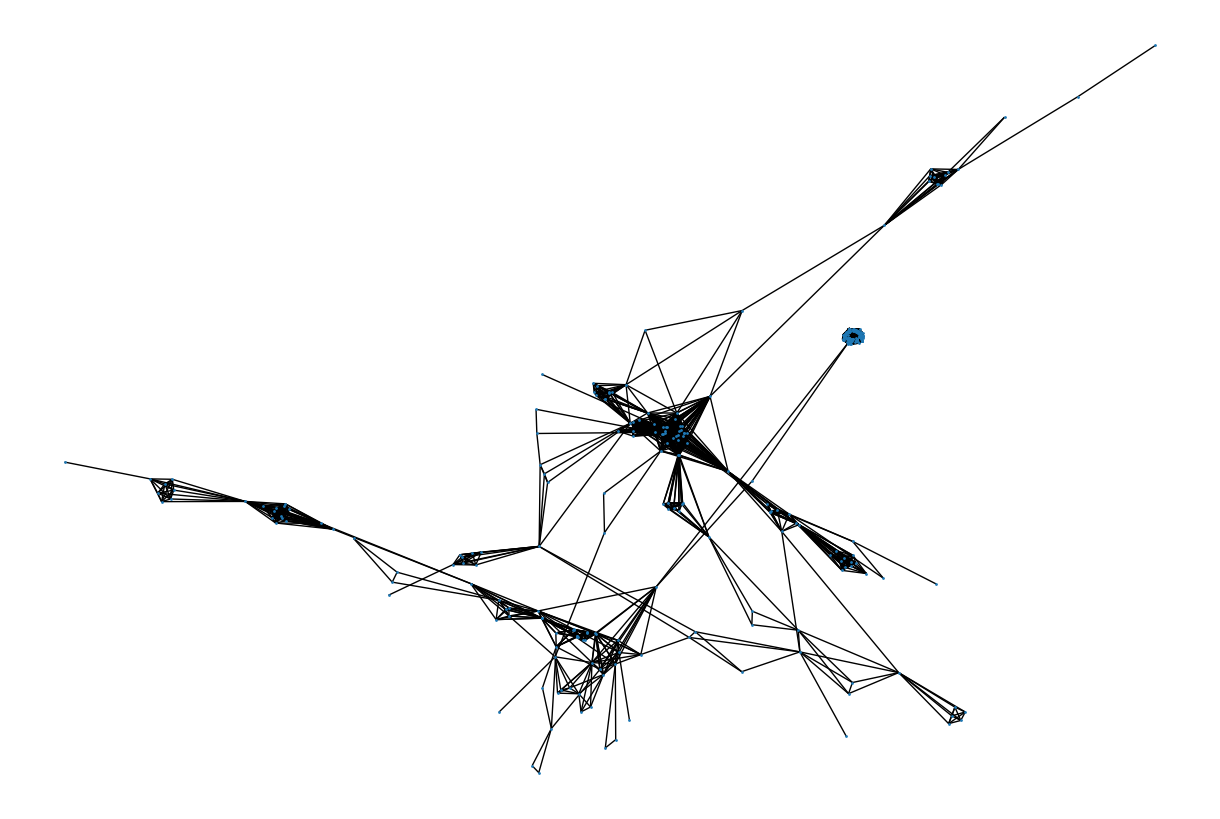

html
0
1000
2000
3000
4000
5000
6000
7000
Number of nodes: 280
Number of edges: 714
Number of nodes of largest component: 22


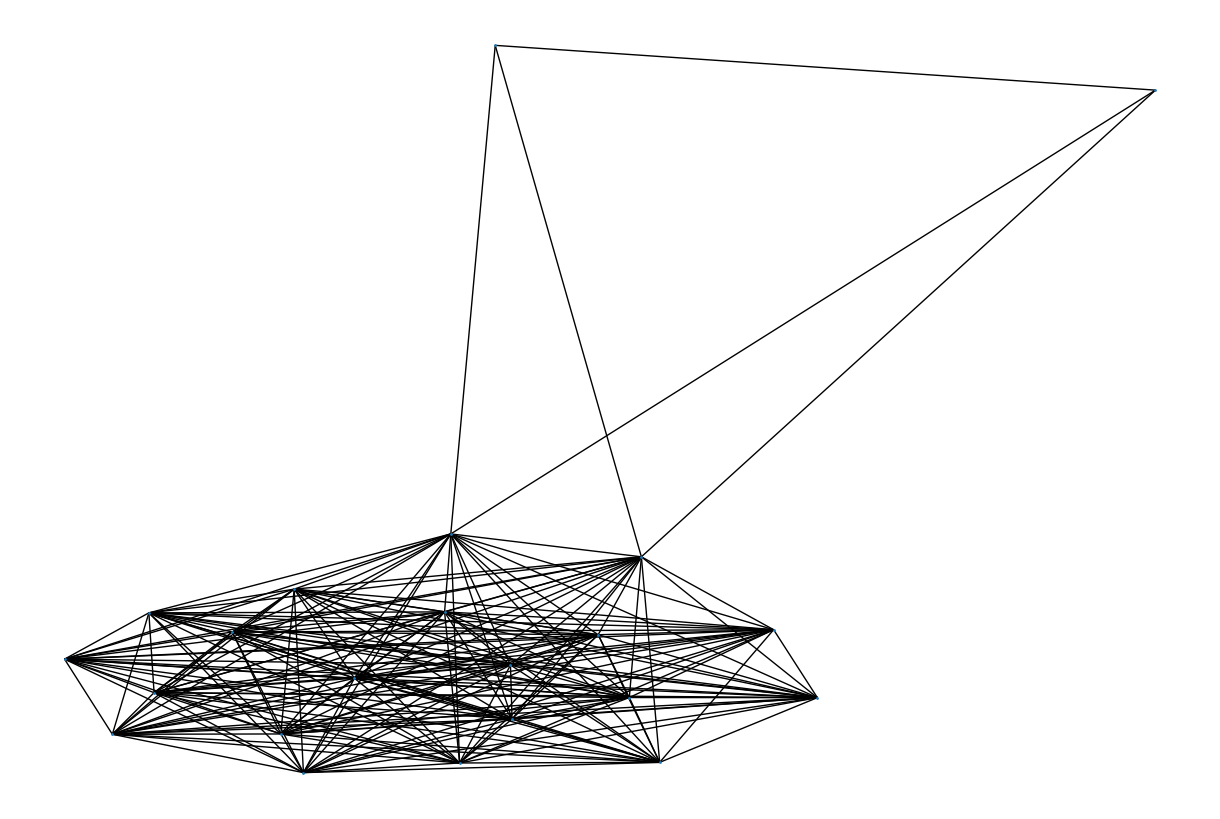

python
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Number of nodes: 686
Number of edges: 2369
Number of nodes of largest component: 57


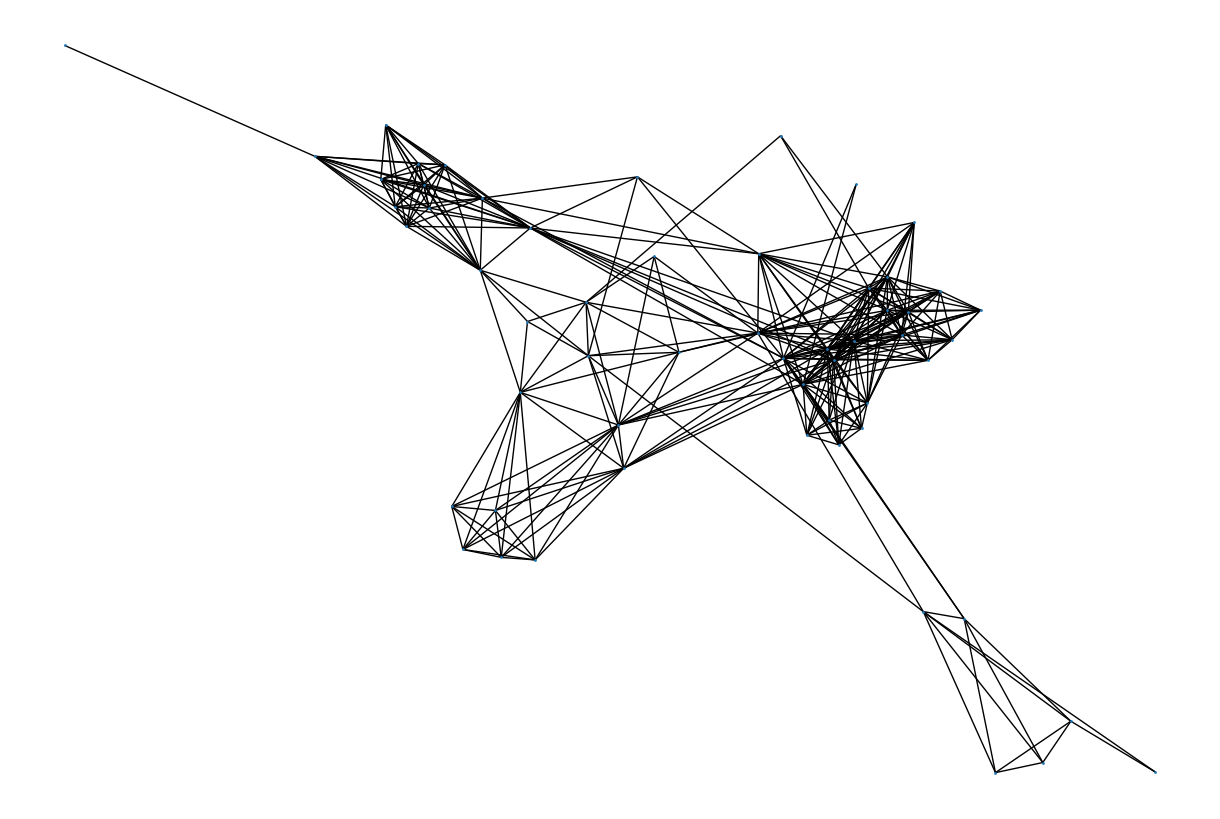

ruby
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
Number of nodes: 587
Number of edges: 3373
Number of nodes of largest component: 55


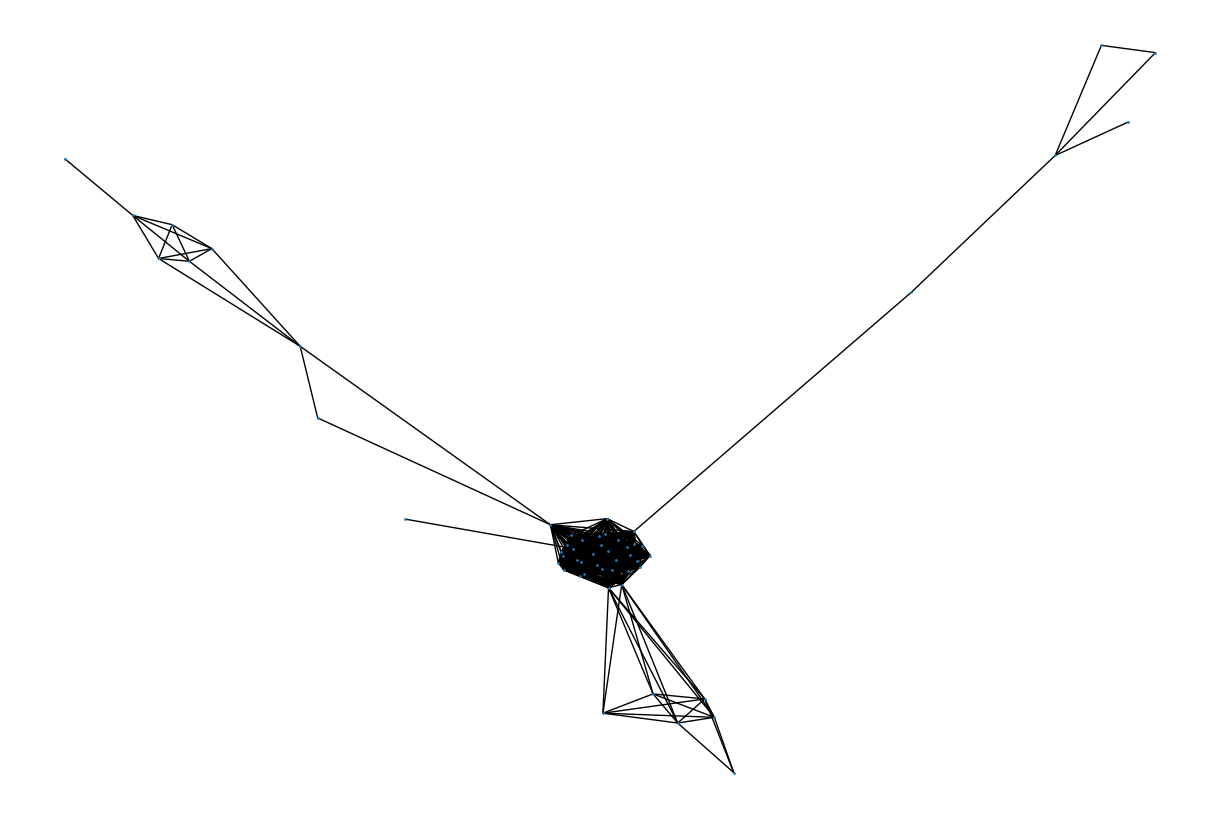

php
0
1000
2000
3000
4000
5000
6000
Number of nodes: 479
Number of edges: 16228
Number of nodes of largest component: 176


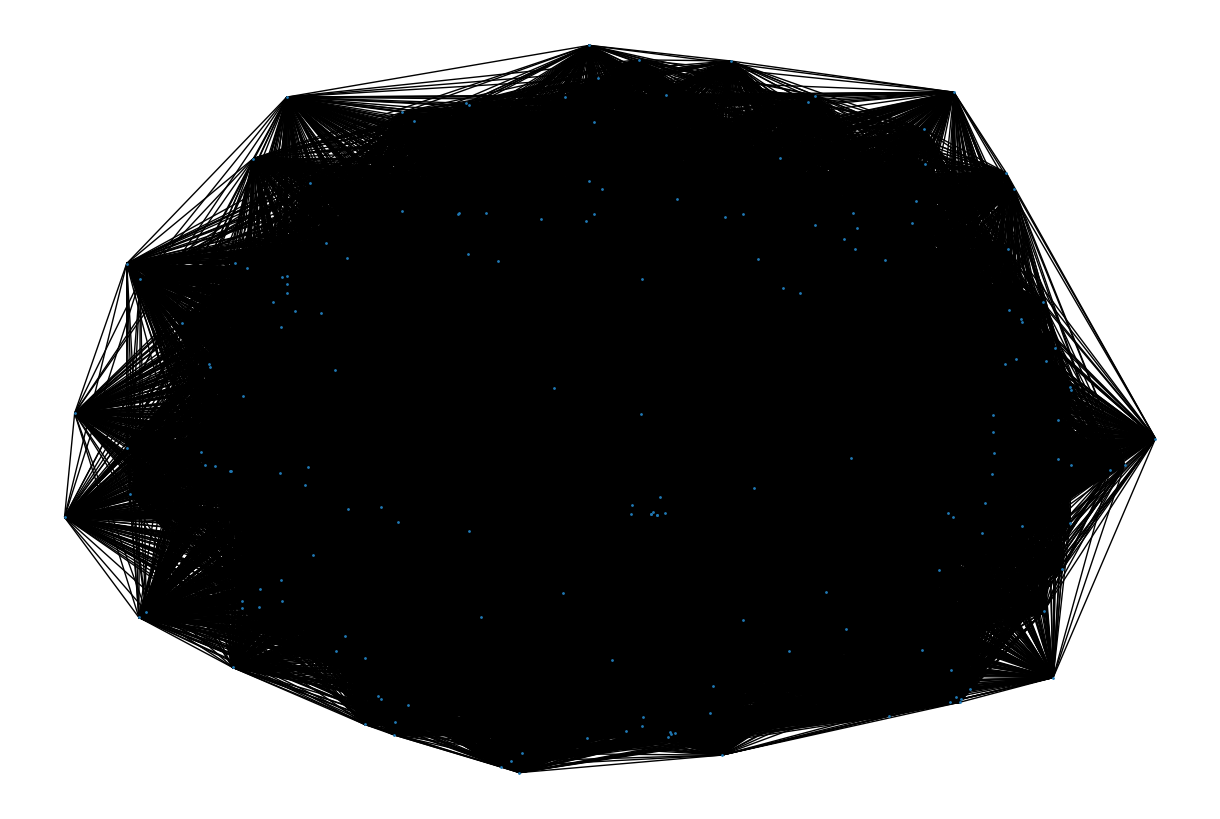

java
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Number of nodes: 628
Number of edges: 6725
Number of nodes of largest component: 100


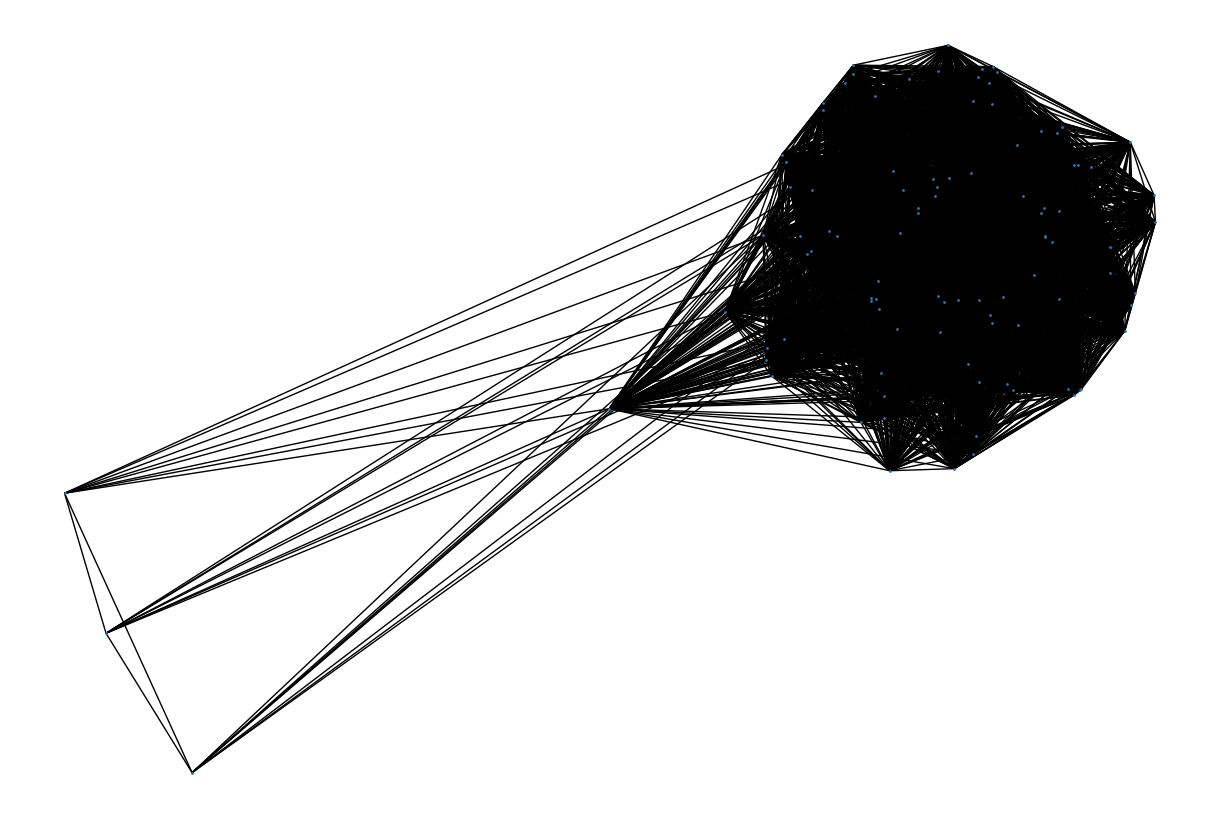

In [20]:
# Create dataset
for k in ["c", "javascript", "html", "python", "ruby", "php", "java"]:
    print(k)
    create_database(k)